# 164992_Fitting+MCMC

Using HD164992 dataset, we demonstrate how to

- perform a max-likelihood fit (with multiple telescopes)
- do an MCMC exploration of the posterior space (with multiple telescopes)


In [1]:
# Preliminary imports
#%pylab osx
%pylab inline
import radvel
import radvel.likelihood
from radvel.plot import orbit_plots
import copy
import pandas as pd
import os
from scipy import optimize
import corner
from astropy.time import Time
import numpy as np
from numpy import *
import copy

rcParams['font.size'] = 18

Populating the interactive namespace from numpy and matplotlib


/Users/bjfulton/anaconda3/lib/python3.6/site-packages/emcee-2.2.1-py3.6.egg/emcee/ptsampler.py:36: DeprecationWarning: invalid escape sequence \e
/Users/bjfulton/anaconda3/lib/python3.6/site-packages/astropy/extern/bundled/six.py:60: ResourceWarning: unclosed file <_io.TextIOWrapper name='/Users/bjfulton/anaconda3/lib/python3.6/site-packages/astropy/extern/bundled/six.py' mode='r' encoding='utf-8'>
  class X(object):
/Users/bjfulton/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/Users/bjfulton/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)
/Users/bjfulton/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args,

In [2]:
def bin_same_night(rv):
    rv['jd_date'] = rv['time'].apply(lambda x: np.int(np.floor(x)))
    rv_mean = rv.groupby('jd_date',as_index=False).mean()
    rv_n = rv.groupby('jd_date',as_index=False).size()
    print(rv['tel'].iloc[0])
    print(len(rv_n))
    rv_mean['errvel'] = rv_mean['errvel'] / np.array(np.sqrt(rv_n))
    return rv_mean

path = os.path.join(radvel.DATADIR,'164922_fixed.txt')
data = pd.read_csv(path, usecols=(0,1,2,3), delim_whitespace=True)

rv_hires_rk = data.query("tel == 'k'")
rv_hires_rj = data.query("tel == 'j'")
rv_apf = data.query("tel == 'a'")

rv_hires_rj = bin_same_night(rv_hires_rj)
rv_hires_rk = bin_same_night(rv_hires_rk)
rv_apf = bin_same_night(rv_apf)

t_start = min(data['time'].values)
t_stop = max(data['time'].values)
ti = linspace(t_start,t_stop,10000)

j
122
k
49
a
69


/Users/bjfulton/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [3]:
#Some conveinence functions
def initialize_model():
    time_base = 2456778
    params = radvel.Parameters(2,basis='per tc secosw sesinw logk')
    params['per1'] = radvel.Parameter(value=1201.1 + 0.4)
    params['tc1'] = radvel.Parameter(value=2456778 + 1)
    params['secosw1'] = radvel.Parameter(value=0.01)
    params['sesinw1'] = radvel.Parameter(value=0.01)
    params['logk1'] = radvel.Parameter(value=1)
    params['per2'] = radvel.Parameter(value=75.765 + 0.1)
    params['tc2'] = radvel.Parameter(value=2456277.6)
    params['secosw2'] = radvel.Parameter(value=0.01)
    params['sesinw2'] = radvel.Parameter(value=0.01)
    params['logk2'] = radvel.Parameter(value=1)
    params['dvdt'] = radvel.Parameter(value=0)
    params['curv'] = radvel.Parameter(value=0)
    mod = radvel.RVModel(params, time_base=time_base)
    return mod


# Max-likelihood fitting

1. Initialize model
2. Build up likelihoods
3. Instantiate posterior
4. Perform fit

In [4]:
def initialize_likelihood(rv,suffix):
    like = radvel.likelihood.RVLikelihood( 
        mod, rv.time, rv.mnvel, rv.errvel,suffix=suffix)
    return like
mod = initialize_model()

# Build up HIRES >2004 likelihood
like_hires_rj = initialize_likelihood(rv_hires_rj,'_hires_rj')
like_hires_rj.params['gamma_hires_rj'] = radvel.Parameter(value=1.0)
like_hires_rj.params['jit_hires_rj'] = radvel.Parameter(value=np.log(1))

# Build up HIRES <2004 likelihood
like_hires_rk = initialize_likelihood(rv_hires_rk,'_hires_rk')
like_hires_rk.params['gamma_hires_rk'] = radvel.Parameter(value=1.0)
like_hires_rk.params['jit_hires_rk'] = radvel.Parameter(value=np.log(1))

# Build up APF
like_apf = initialize_likelihood(rv_apf,'_apf')
like_apf.params['gamma_apf'] = radvel.Parameter(value=1.0)
like_apf.params['jit_apf'] = radvel.Parameter(value=np.log(1))

# Build composite likelihood
like = radvel.likelihood.CompositeLikelihood(
    [like_hires_rj,like_hires_rk,like_apf])

# Set initial values for jitter
like.params['jit_hires_rk'] = radvel.Parameter(value=log(2.6))
like.params['jit_hires_rj'] = radvel.Parameter(value=log(2.6))
like.params['jit_apf'] = radvel.Parameter(value=log(2.6))

# Do not vary dvdt or jitter (Fulton 2015)
like.params['dvdt'].vary = False
like.params['curv'].vary = False
like.params['jit_hires_rk'].vary = False
like.params['jit_hires_rj'].vary = False
like.params['jit_apf'].vary = False

In [5]:
# Instantiate posterior
post = radvel.posterior.Posterior(like)
post0 = copy.deepcopy(post)

# Add in priors
post.priors += [radvel.prior.EccentricityPrior( 2 )] # Keeps eccentricity < 1

# Perform Max-likelihood fitting
res  = optimize.minimize(
    post.neglogprob_array,
    post.get_vary_params(), 
    method='Powell',
    options=dict(maxiter=100000,maxfev=100000,xtol=1e-8)
    )

print("Initial loglikelihood = %f" % post0.logprob())
print("Final loglikelihood = %f" % post.logprob())
print(post)

Initial loglikelihood = -1418.041736
Final loglikelihood = -764.756373
parameter                     value      vary
per1                        1199.28       True
tc1                         6779.48       True
secosw1                   -0.238608       True
sesinw1                    0.252247       True
logk1                        1.9721       True
per2                        75.7715       True
tc2                         6277.94       True
secosw2                   0.0069338       True
sesinw2                    0.437631       True
logk2                      0.766698       True
dvdt                              0      False
curv                              0      False
gamma_hires_rj             0.224739       True
jit_hires_rj               0.955511      False
gamma_hires_rk             0.154315       True
jit_hires_rk               0.955511      False
gamma_apf                   1.02202       True
jit_apf                    0.955511      False

Priors
------
e1 constrained to be <

# Perform MCMC posterior exploration

In [6]:
df = radvel.mcmc(post, nrun=200)

20000/80000 (25.0%) steps complete; Running 13596.89 steps/s; Mean acceptance rate = 43.1%; Min Tz = 3123.9; Max G-R = 1.009      
Discarding burn-in now that the chains are marginally well-mixed

80000/80000 (100.0%) steps complete; Running 12753.20 steps/s; Mean acceptance rate = 37.2%; Min Tz = 4138.9; Max G-R = 1.007      

MCMC: WARNING: chains did not pass 5 consecutive convergence tests. They may be marginally well=mixed.


In [7]:
df_synth = post.params.basis.to_synth(df)
labels = 'per1 tc1 e1 k1 per2 tc2 e2 k2 gamma_hires_rj gamma_hires_rk gamma_apf '.split()
df_synth[labels].quantile([0.14,0.5,0.84]).T

,0.14,0.5,0.84
per1,1.198795e+03,1.199285e+03,1.199722e+03
tc1,2.456778e+06,2.456780e+06,2.456781e+06
e1,1.005803e-01,1.215133e-01,1.421600e-01
k1,6.974056e+00,7.177979e+00,7.371577e+00
per2,7.575383e+01,7.577262e+01,7.579032e+01
tc2,2.456277e+06,2.456278e+06,2.456279e+06
e2,1.011031e-01,1.802188e-01,2.441431e-01
k2,1.929147e+00,2.131403e+00,2.301463e+00
gamma_hires_rj,8.718594e-02,2.297368e-01,3.575205e-01
gamma_hires_rk,-1.690391e-02,1.532531e-01,3.158029e-01


Compare with parameters from fulton et al. (2016)
---------

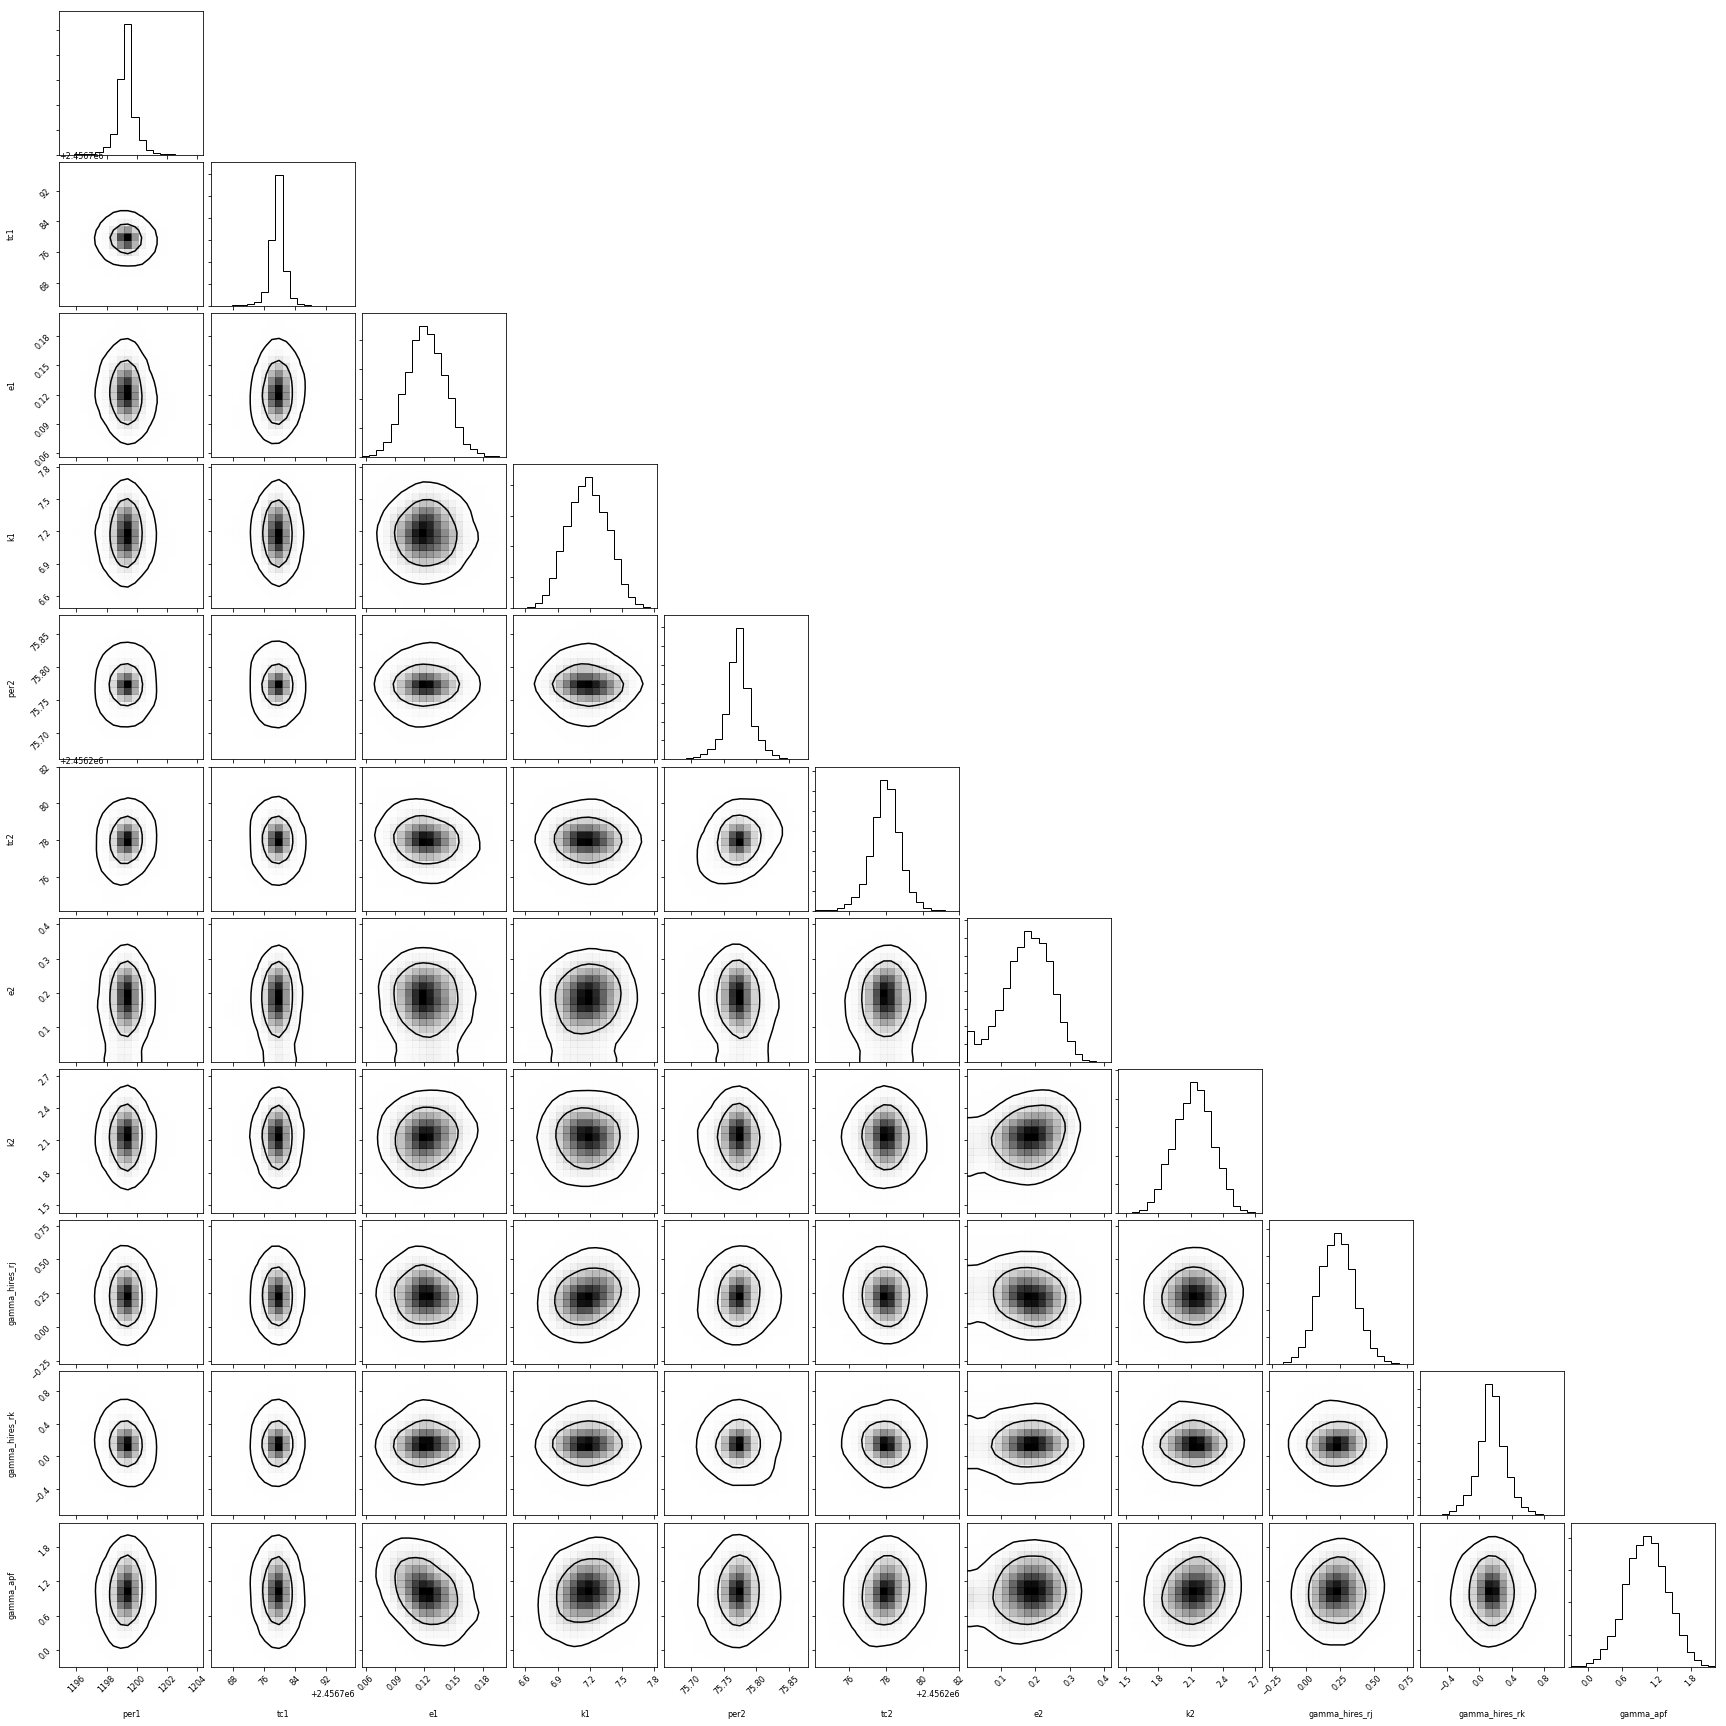

In [8]:
labels = 'per1 tc1 e1 k1 per2 tc2 e2 k2 gamma_hires_rj gamma_hires_rk gamma_apf '.split()
rc('font',size=8)

fig = corner.corner(
    df_synth[labels],labels=labels,
    levels=[0.68,0.95],plot_datapoints=False,smooth=True,bins=20
    )

(<Figure size 540x786.857 with 5 Axes>,
  <matplotlib.axes._subplots.AxesSubplot at 0x1a261f2be0>])

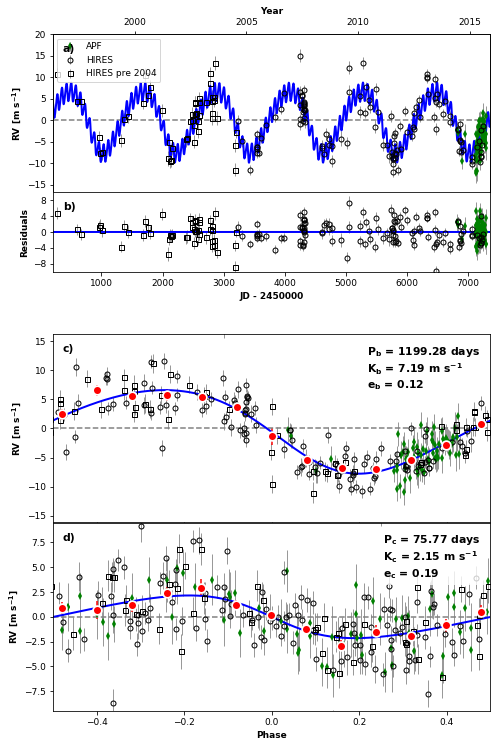

In [9]:
RVPlot = orbit_plots.MultipanelPlot(post)
RVPlot.plot_multipanel()